This notebook shows how BigBang can help you analyze the senders in a particular mailing list archive.

First, use this IPython magic to tell the notebook to display matplotlib graphics inline. This is a nice way to display results.

In [1]:
%matplotlib inline

Import the BigBang modules as needed. These should be in your Python environment if you've installed BigBang correctly.

In [2]:
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
reload(process)

<module 'bigbang.process' from '/home/gogol/Data/bigbang/bigbang/process.pyc'>

Also, let's import a number of other dependencies we'll use later.

In [3]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os

pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options

/home/gogol/Data/Anaconda2/envs/bigbang/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


Now let's load the data for analysis.

In [4]:
urls = ["http://mm.icann.org/pipermail/cc-humanrights/",
        "http://lists.ncuc.org/pipermail/ncuc-discuss/"]
mlists = [mailman.open_list_archives(url,"../archives") for url in urls]
activities = [Archive.get_activity(Archive(ml)) for ml in mlists]

Opening 18 archive files
Opening 171 archive files


/home/gogol/Data/bigbang/bigbang/archive.py:74: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  self.data.sort(columns='Date', inplace=True)


This variable is for the range of days used in computing rolling averages.


Now, let's see: who are the authors of the most messages to one particular list?

/home/gogol/Data/Anaconda2/envs/bigbang/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


/home/gogol/Data/Anaconda2/envs/bigbang/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


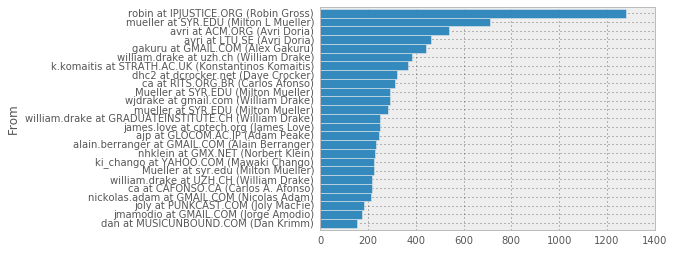

In [5]:
a  = activities[1] # for the first mailing list
ta = a.sum(0) # sum along the first axis
ta.sort()
ta[-25:].plot(kind='barh', width=1)

This might be useful for seeing the distribution (does the top message sender dominate?) or for identifying key participants to talk to.

---

Many mailing lists will have some duplicate senders: individuals who use multiple email addresses or are recorded as different senders when using the same email address. We want to identify those potential duplicates in order to get a more accurate representation of the distribution of senders.

To begin with, let's calculate the similarity of the From strings, based on the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance).

In [6]:
levdf = process.sorted_matrix(a) # creates a slightly more nuanced edit distance matrix
                                 # and sorts by rows/columns that have the best candidates
levdf_corner = levdf.iloc[:25,:25] # just take the top 25

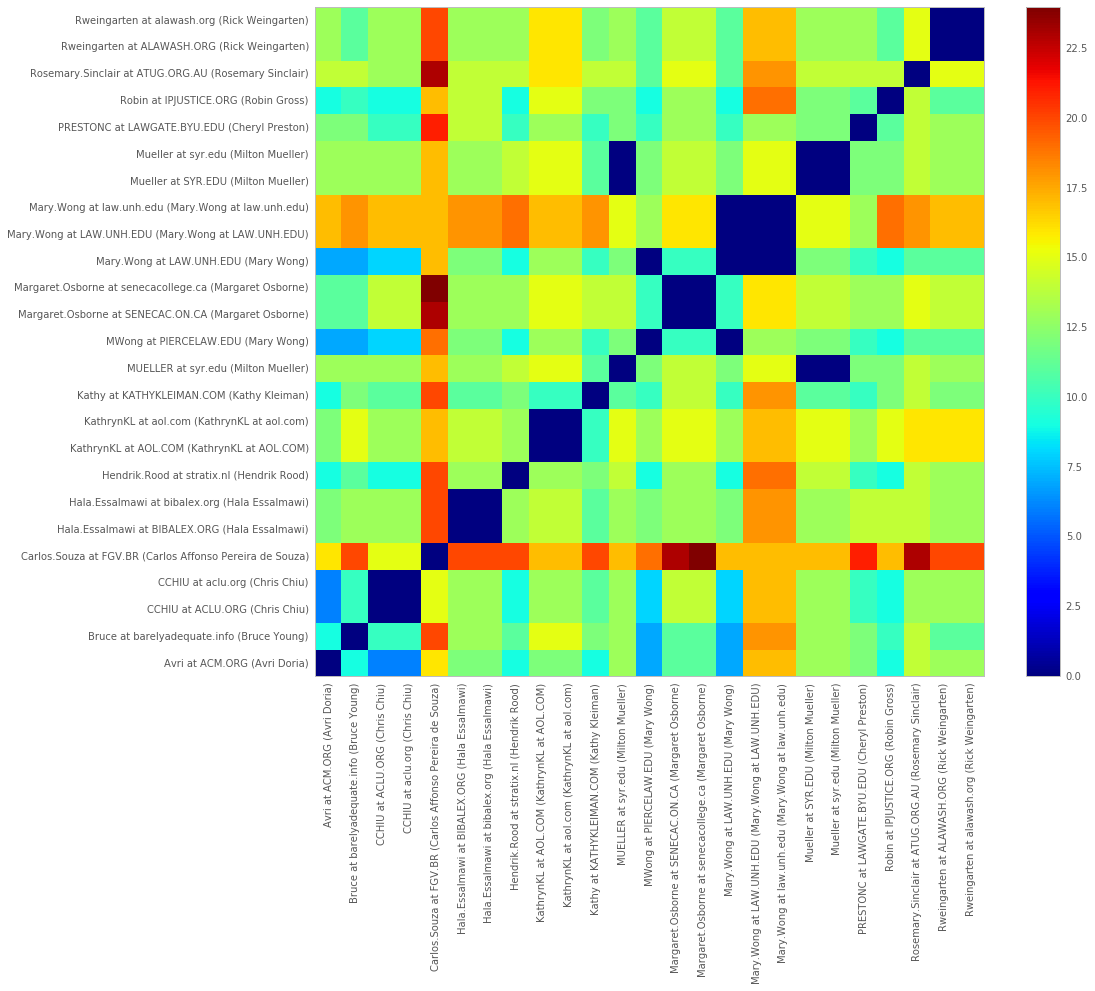

In [7]:
fig = plt.figure(figsize=(15, 12))
plt.pcolor(levdf_corner)
plt.yticks(np.arange(0.5, len(levdf_corner.index), 1), levdf_corner.index)
plt.xticks(np.arange(0.5, len(levdf_corner.columns), 1), levdf_corner.columns, rotation='vertical')
plt.colorbar()
plt.show()

For this still naive measure (edit distance on a normalized string), it appears that there are many duplicates in the &lt;10 range, but that above that the edit distance of short email addresses at common domain names can take over.

In [8]:
consolidates = []

# gather pairs of names which have a distance of less than 10
for col in levdf.columns:
  for index, value in levdf.loc[levdf[col] < 10, col].iteritems():
        if index != col: # the name shouldn't be a pair for itself
            consolidates.append((col, index))
  
print str(len(consolidates)) + ' candidates for consolidation.'

42992 candidates for consolidation.


In [9]:
c = process.consolidate_senders_activity(a, consolidates)
print 'We removed: ' + str(len(a.columns) - len(c.columns)) + ' columns.'

We removed: 550 columns.


We can create the same color plot with the consolidated dataframe to see how the distribution has changed.

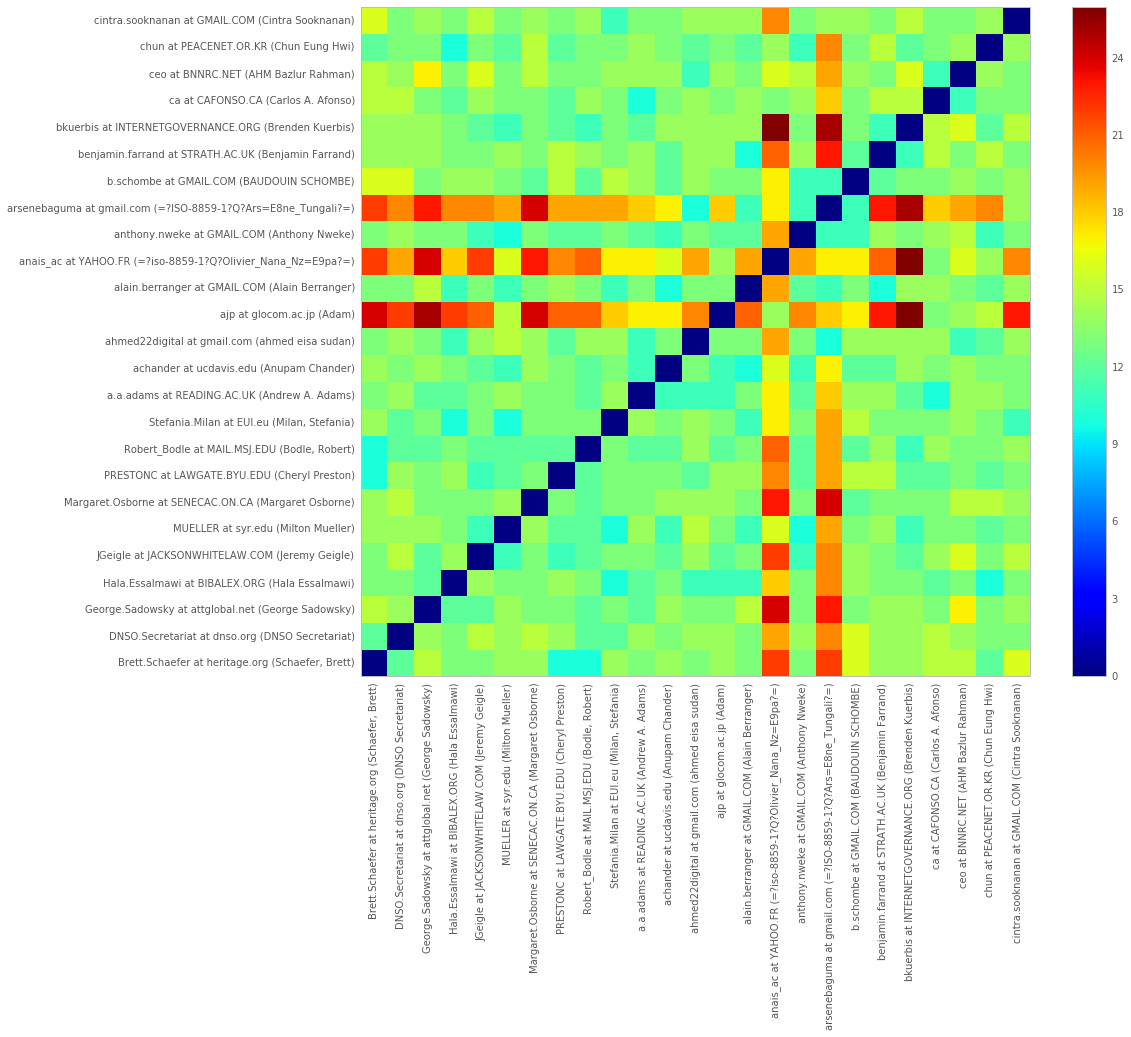

In [10]:
lev_c = process.sorted_matrix(c)
levc_corner = lev_c.iloc[:25,:25]
fig = plt.figure(figsize=(15, 12))
plt.pcolor(levc_corner)
plt.yticks(np.arange(0.5, len(levc_corner.index), 1), levc_corner.index)
plt.xticks(np.arange(0.5, len(levc_corner.columns), 1), levc_corner.columns, rotation='vertical')
plt.colorbar()
plt.show()

Of course, there are still some duplicates, mostly people who are using the same name, but with a different email address at an unrelated domain name.

How does our consolidation affect the graph of distribution of senders?

/home/gogol/Data/Anaconda2/envs/bigbang/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
/home/gogol/Data/Anaconda2/envs/bigbang/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


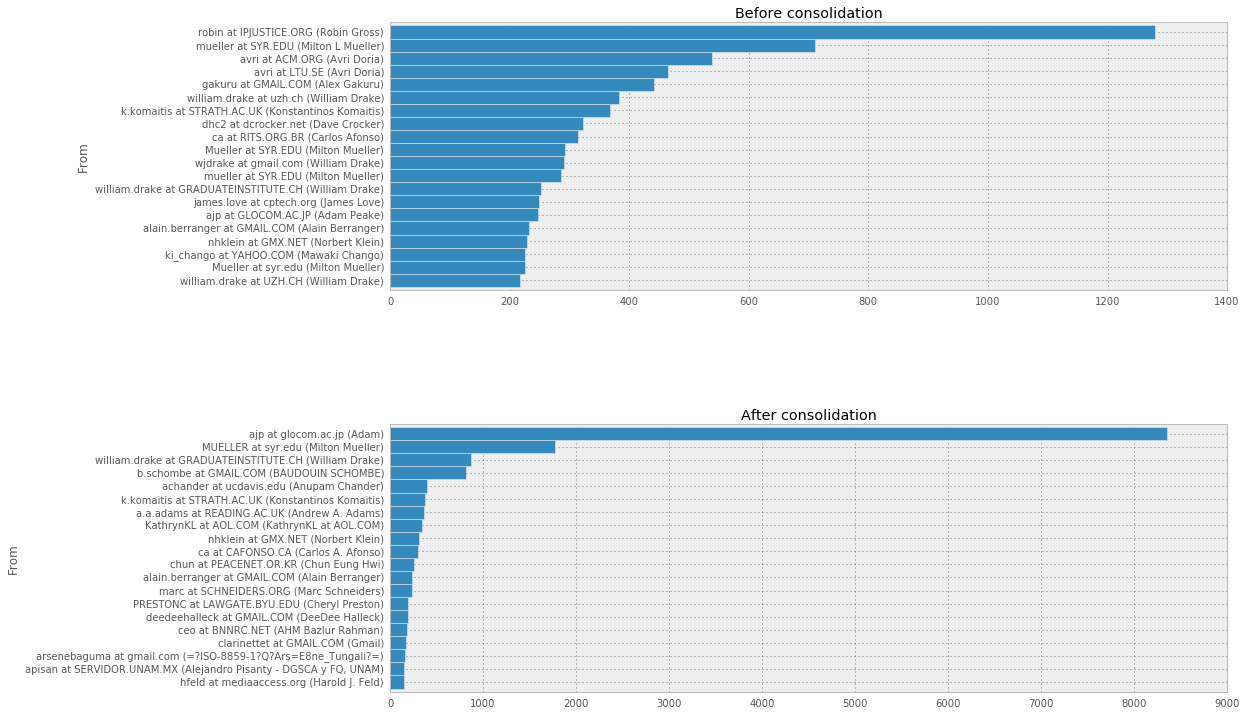

In [11]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 12))

ta = a.sum(0) # sum along the first axis
ta.sort()
ta[-20:].plot(kind='barh',ax=axes[0], width=1, title='Before consolidation')
tc = c.sum(0)
tc.sort()
tc[-20:].plot(kind='barh',ax=axes[1], width=1, title='After consolidation')
plt.show()

Okay, not dramatically different, but the consolidation makes the head heavier. There are more people close to that high end, a stronger core group and less a power distribution smoothly from one or two people.

We could also use sender email addresses as a naive inference for affiliation, especially for mailing lists where corporate/organizational email addresses are typically used.

Pandas lets us group by the results of a keying function, which we can use to group participants sending from email addresses with the same domain.

In [12]:
grouped = tc.groupby(process.domain_name_from_email)
domain_groups = grouped.size()
domain_groups.sort(ascending=True)
domain_groups[-20:].plot(kind='barh', width=1, title="Number of participants at domain")

IndexError: list index out of range

We can also aggregate the number of messages that come from addresses at each domain. 

In [ ]:
domain_messages_sum = grouped.sum()
domain_messages_sum.sort(ascending=True)
domain_messages_sum[-20:].plot(kind='barh', width=1, title="Number of messages from domain")

This shows distinct results from the participants and from the top individual contributors. For example, while there are many @gmail.com addresses among the participants, they don't send as many messages. Microsoft, Google and Mozilla (major browser vendors) send many messages to the list as a domain even though no individual from those organizations is among the top senders.